# TD2 Eplainability-AI

In [3]:
#The librairies we will be using
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn import tree


In [4]:
#First We import our data
df = pd.read_csv('NY-House-Dataset.csv', sep = ',')

## QUESTION 1

In [5]:
#We check for any missing values
df.info()
df['BROKER_NAME'] = df['BROKERTITLE'].str.split('-', n=1).str[0].str.strip()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4801 entries, 0 to 4800
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4801 non-null   object 
 1   TYPE                         4801 non-null   object 
 2   PRICE                        4801 non-null   int64  
 3   BEDS                         4801 non-null   int64  
 4   BATH                         4801 non-null   float64
 5   PROPERTYSQFT                 4801 non-null   float64
 6   ADDRESS                      4801 non-null   object 
 7   STATE                        4801 non-null   object 
 8   MAIN_ADDRESS                 4801 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4801 non-null   object 
 10  LOCALITY                     4801 non-null   object 
 11  SUBLOCALITY                  4801 non-null   object 
 12  STREET_NAME                  4801 non-null   object 
 13  LONG_NAME         

Our data set has 4801 entries so it contains the informations about 4801 apartment.

What are the caracteristics of the most expensive apartment?

In [6]:
#we look for the most expensive apartment
print(df.loc[df["PRICE"].idxmax()])


BROKERTITLE                              Brokered by ANNE LOPA REAL ESTATE
TYPE                                                        House for sale
PRICE                                                           2147483647
BEDS                                                                     7
BATH                                                                   6.0
PROPERTYSQFT                                                       10000.0
ADDRESS                                                 6659-6675 Amboy Rd
STATE                                                   New York, NY 10309
MAIN_ADDRESS                          6659-6675 Amboy RdNew York, NY 10309
ADMINISTRATIVE_AREA_LEVEL_2                                  United States
LOCALITY                                                          New York
SUBLOCALITY                                                Richmond County
STREET_NAME                                                  Staten Island
LONG_NAME                

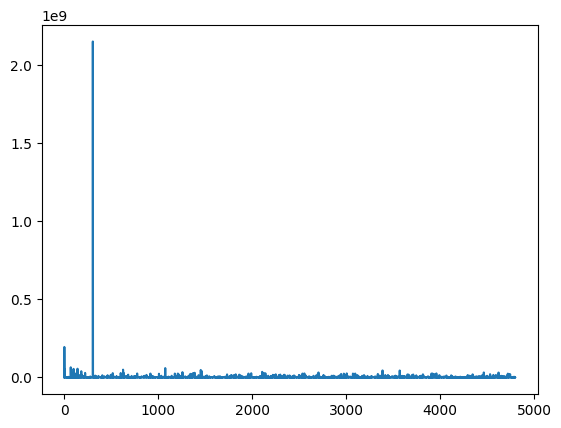

In [7]:
plt.plot(df["PRICE"])

It seems like the most expensive apartment is an irregularity. When we looked for this 3 billion property on Google Maps, we can see that it is a small house on Staten Island in Richmond County, which is a poor neighborhood of New York. I choose to remove this property from the dataset because it doesn't make any sense. Moreover, after further research, I learned that the most expensive property ever sold in New York was a penthouse above Central Park, which was sold for around 300 million dollars. To keep a little margin, I removed all the properties above 400 million. Check for mistakes.

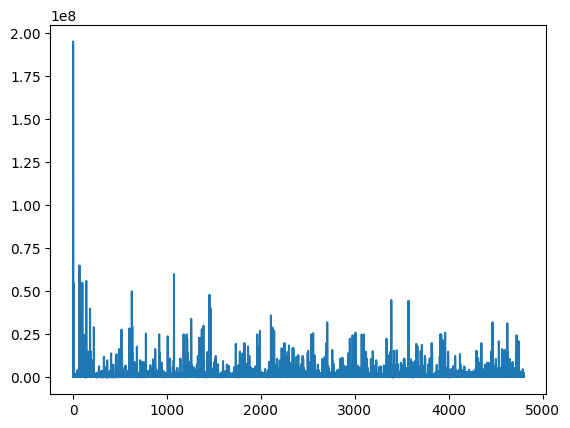

In [8]:
df = df[df["PRICE"] <= 400000000]
plt.plot(df["PRICE"])

In [9]:
print(df.loc[df["PRICE"].idxmax()])


BROKERTITLE                                                  Brokered by Serhant
TYPE                                                              Condo for sale
PRICE                                                                  195000000
BEDS                                                                           7
BATH                                                                        10.0
PROPERTYSQFT                                                             17545.0
ADDRESS                        Central Park Tower Penthouse-217 W 57th New Yo...
STATE                                                         New York, NY 10019
MAIN_ADDRESS                   Central Park Tower Penthouse-217 W 57th New Yo...
ADMINISTRATIVE_AREA_LEVEL_2                                        United States
LOCALITY                                                                New York
SUBLOCALITY                                                      New York County
STREET_NAME                 

Now we can see that the most expensive property is a 200 million penthouse above Central Park.

In [10]:
#conversion to m2
df["SIZE_m2"] = df["PROPERTYSQFT"] * 0.092903

In [11]:
df["Price_per_m2"] = df["PRICE"] / df["SIZE_m2"]


In [12]:
#We assume that an appartment of more than 100 m2 is a big appartment
threshold_size = 100

big_apartments = df[df["SIZE_m2"] > threshold_size]
small_apartments = df[df["SIZE_m2"] <= threshold_size]

avg_price_per_m2_big = big_apartments["Price_per_m2"].mean()
avg_price_per_m2_small = small_apartments["Price_per_m2"].mean()

print("Average price per square meter for big apartments:", avg_price_per_m2_big)
print("Average price per square meter for small apartments:", avg_price_per_m2_small)


Average price per square meter for big apartments: 8663.814689839652
Average price per square meter for small apartments: 7291.664303150904


The big apartments are more expensive per square meter.

Here are the mean prices for the most expensive brokers.

In [13]:
# We assume that the brokers with a mean price of more than 2 millions are luxury brokers.
broker_grp = df.groupby("BROKER_NAME")["PRICE"].mean()
luxury_brokers = broker_grp[broker_grp > 3000000]

print("Luxury Brokers:")
luxury_brokers

Luxury Brokers:


BROKER_NAME
Brokered by American Dream Kalaba Realty LLC            3.200000e+06
Brokered by Andrew Lichtenstein Inc                     3.925000e+06
Brokered by BHHS New York Properties                    3.683846e+06
Brokered by BROWN HARRIS STEVENS BROOKLYN LLC           3.456333e+06
Brokered by Blue Key Real Estate Brokerage              1.100000e+07
Brokered by Brownstone Real Estate LLC                  3.327667e+06
Brokered by CHRISTIE'S INT.REAL ESTATE GROUP            8.465833e+06
Brokered by CORE Group Marketing, LLC                   8.207812e+06
Brokered by Coldwell Banker Warburg                     4.130000e+06
Brokered by Connie Profaci Realty                       4.195800e+06
Brokered by Corcoran Chelsea/Flatiron                   3.471159e+06
Brokered by Corcoran East Side                          6.222708e+06
Brokered by Corcoran SoHo                               3.521038e+06
Brokered by Corcoran West Side                          3.850653e+06
Brokered by DEGI      

In [14]:
avg_price_per_area = df.groupby('LOCALITY')['PRICE'].mean()

most_expensive_area = avg_price_per_area.idxmax()
cheapest_area = avg_price_per_area.idxmin()

avg_price_most_expensive = avg_price_per_area[most_expensive_area]
avg_price_cheapest = avg_price_per_area[cheapest_area]

print("Most Expensive Area:", most_expensive_area)
print("Average Price in the Most Expensive Area:", avg_price_most_expensive)

print("\nCheapest Area:", cheapest_area)
print("Average Price in the Cheapest Area:", avg_price_cheapest)


Most Expensive Area: New York County
Average Price in the Most Expensive Area: 2579619.2298263535

Cheapest Area: The Bronx
Average Price in the Cheapest Area: 330600.0


In [15]:
variance_price_per_area = df.groupby('LOCALITY')['PRICE'].var()

df['PRICE_PER_SQM'] = df['PRICE'] / df['PROPERTYSQFT']
variance_price_per_sqm_per_area = df.groupby('LOCALITY')['PRICE_PER_SQM'].var()

most_varied_price_area = variance_price_per_area.idxmax()
variance_price_in_most_varied_area = variance_price_per_area[most_varied_price_area]

most_varied_price_per_sqm_area = variance_price_per_sqm_per_area.idxmax()
variance_price_per_sqm_in_most_varied_area = variance_price_per_sqm_per_area[most_varied_price_per_sqm_area]

print("Area with the Most Variance in Prices:", most_varied_price_area)
print("Variance in Prices in the Most Varied Area:", variance_price_in_most_varied_area)

print("\nArea with the Most Variance in Price Per Square Meter:", most_varied_price_per_sqm_area)
print("Variance in Price Per Square Meter in the Most Varied Area:", variance_price_per_sqm_in_most_varied_area)


Area with the Most Variance in Prices: New York
Variance in Prices in the Most Varied Area: 35114274000441.273

Area with the Most Variance in Price Per Square Meter: New York County
Variance in Price Per Square Meter in the Most Varied Area: 3048138.445654324


## Question 2

Boxplot of the prices per area

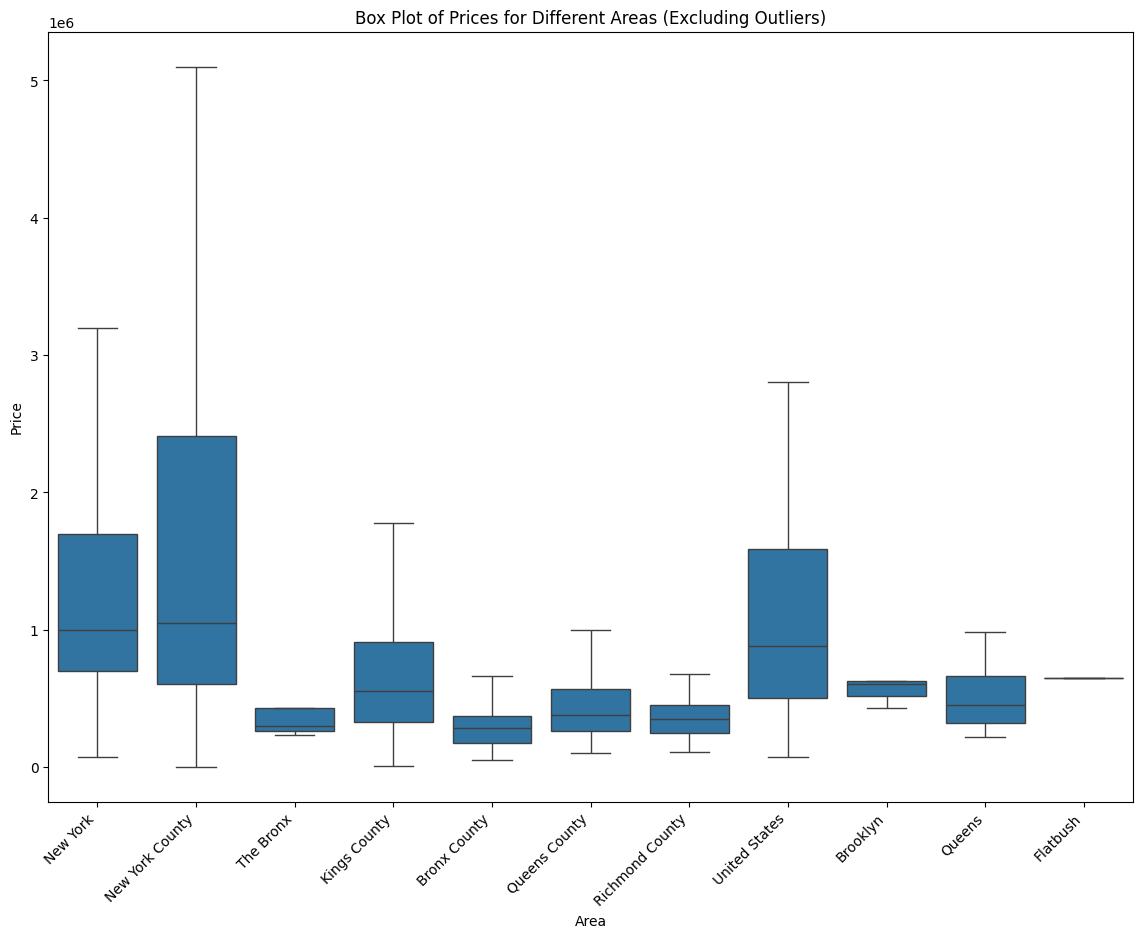

In [16]:
plt.figure(figsize=(14, 10))  

sns.boxplot(x='LOCALITY', y='PRICE', data=df, showfliers=False)
plt.xticks(rotation=45, ha='right', fontsize=10) 
plt.xlabel('Area')
plt.ylabel('Price')
plt.title('Box Plot of Prices for Different Areas (Excluding Outliers)')
plt.show()


Box plot of the prices for the 20 brokers with the most houses.

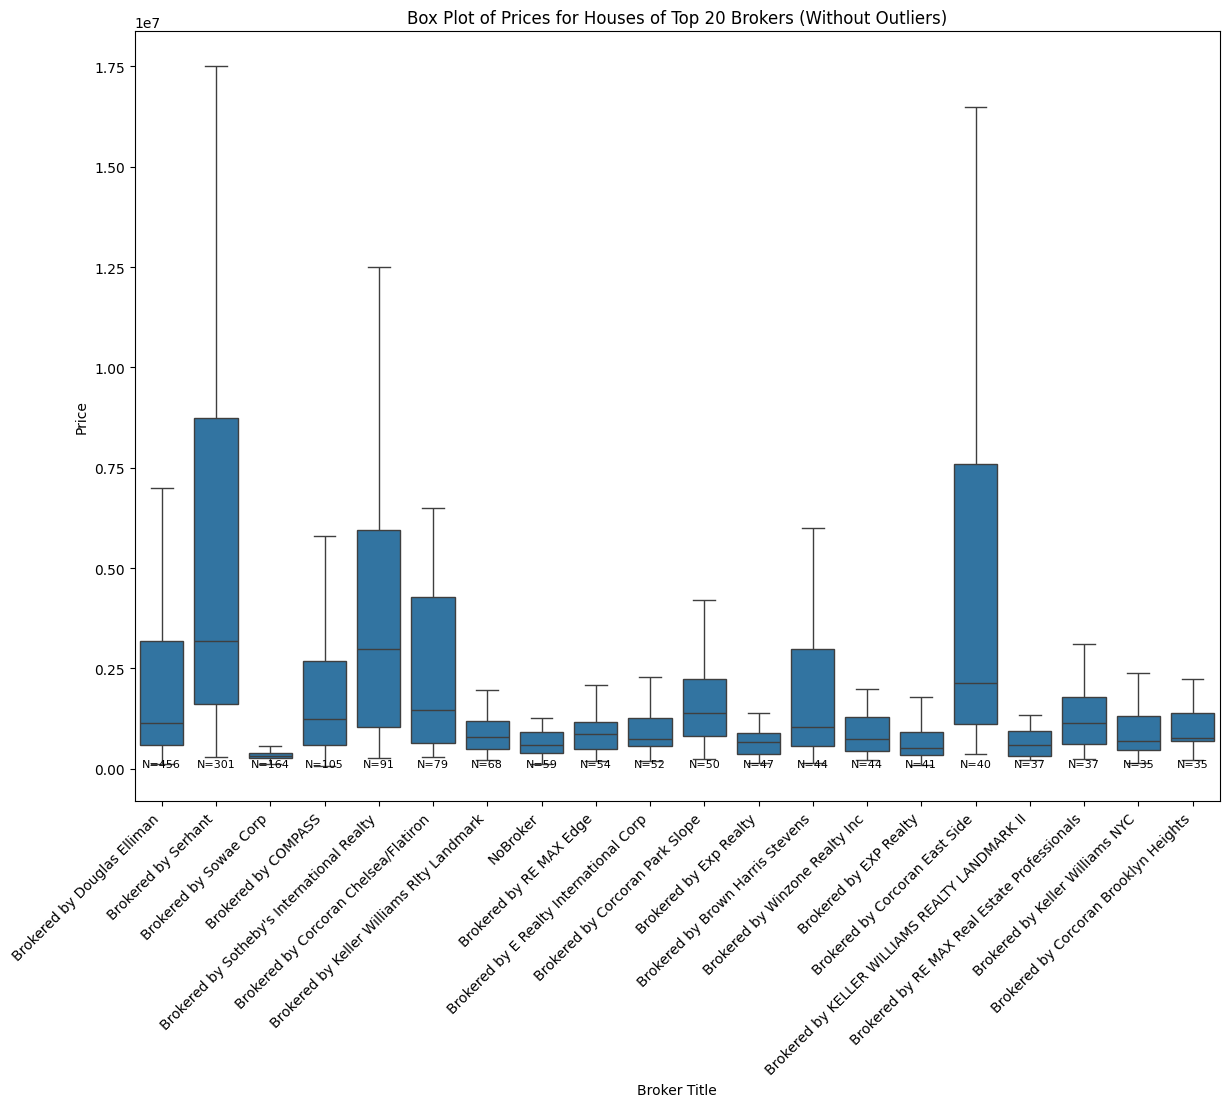

In [17]:
houses_per_broker = df['BROKER_NAME'].value_counts()

top_20_brokers = houses_per_broker.head(20).index

df_top_brokers = df[df['BROKER_NAME'].isin(top_20_brokers)]

plt.figure(figsize=(14, 10))
ax = sns.boxplot(x='BROKER_NAME', y='PRICE', data=df_top_brokers, showfliers=False)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Broker Title')
plt.ylabel('Price')
plt.title('Box Plot of Prices for Houses of Top 20 Brokers (Without Outliers)')

for i, broker in enumerate(top_20_brokers):
    count = houses_per_broker[broker]
    ax.text(i, 0, f'N={count}', ha='center', va='bottom', color='black', fontsize=8)

plt.show()

Box plot of the prices for the top 15 most expensive brokers

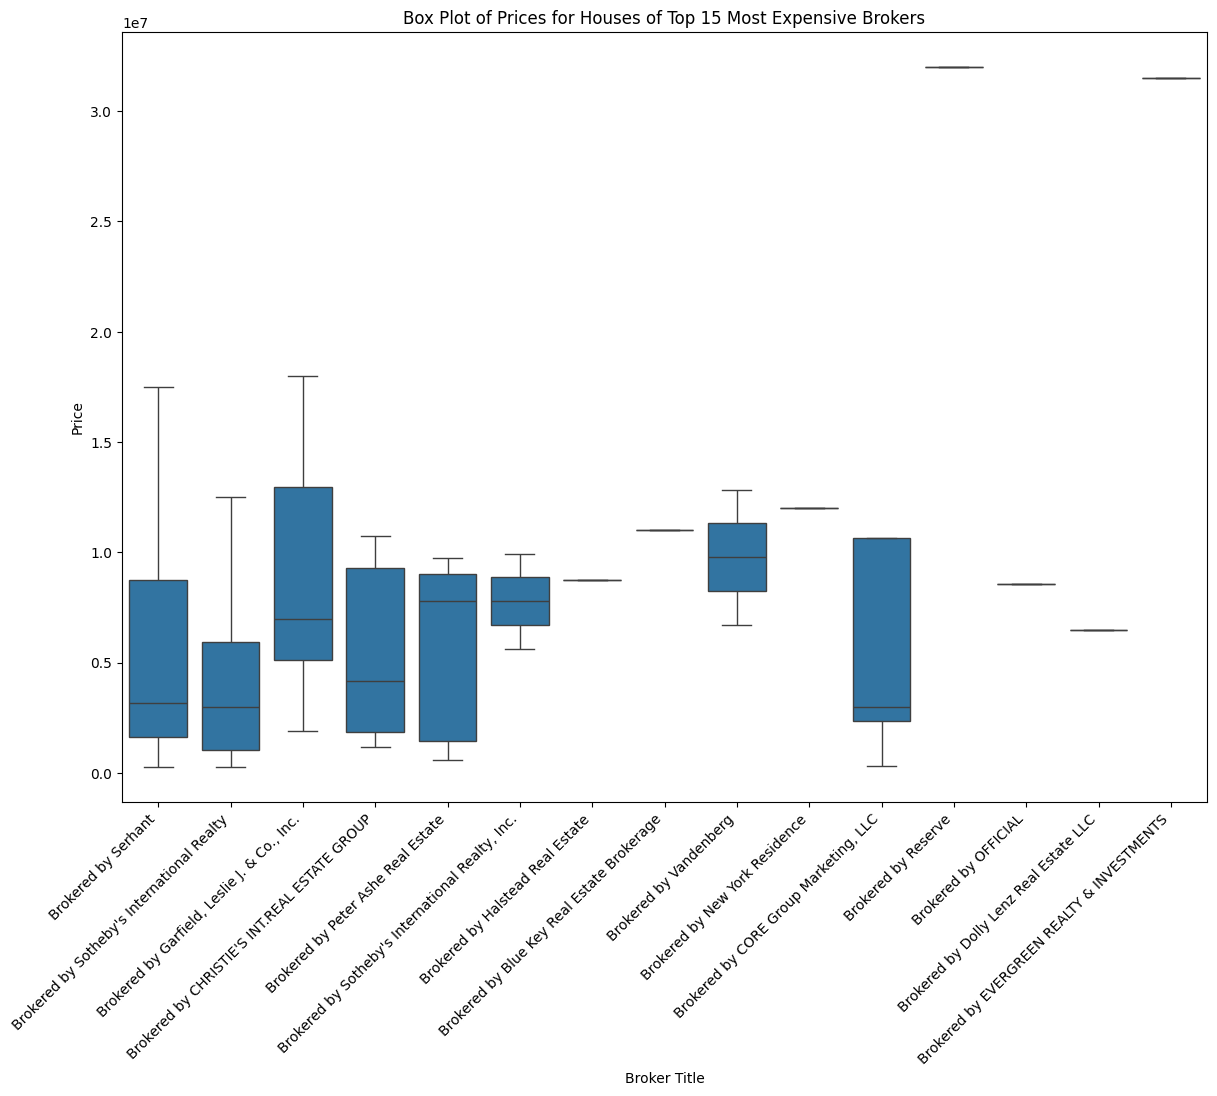

In [18]:
average_price_per_broker = df.groupby('BROKER_NAME')['PRICE'].mean()

top_15_expensive_brokers = average_price_per_broker.nlargest(15)

df_top_expensive_brokers = df[df['BROKER_NAME'].isin(top_15_expensive_brokers.index)]

plt.figure(figsize=(14, 10))
sns.boxplot(x='BROKER_NAME', y='PRICE', data=df_top_expensive_brokers, showfliers=False)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.xlabel('Broker Title')
plt.ylabel('Price')
plt.title('Box Plot of Prices for Houses of Top 15 Most Expensive Brokers')
plt.show()

## QUESTION3

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4800 entries, 0 to 4800
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   BROKERTITLE                  4800 non-null   object 
 1   TYPE                         4800 non-null   object 
 2   PRICE                        4800 non-null   int64  
 3   BEDS                         4800 non-null   int64  
 4   BATH                         4800 non-null   float64
 5   PROPERTYSQFT                 4800 non-null   float64
 6   ADDRESS                      4800 non-null   object 
 7   STATE                        4800 non-null   object 
 8   MAIN_ADDRESS                 4800 non-null   object 
 9   ADMINISTRATIVE_AREA_LEVEL_2  4800 non-null   object 
 10  LOCALITY                     4800 non-null   object 
 11  SUBLOCALITY                  4800 non-null   object 
 12  STREET_NAME                  4800 non-null   object 
 13  LONG_NAME              

First we plot a heatmap to check the correlation between our numerical data.

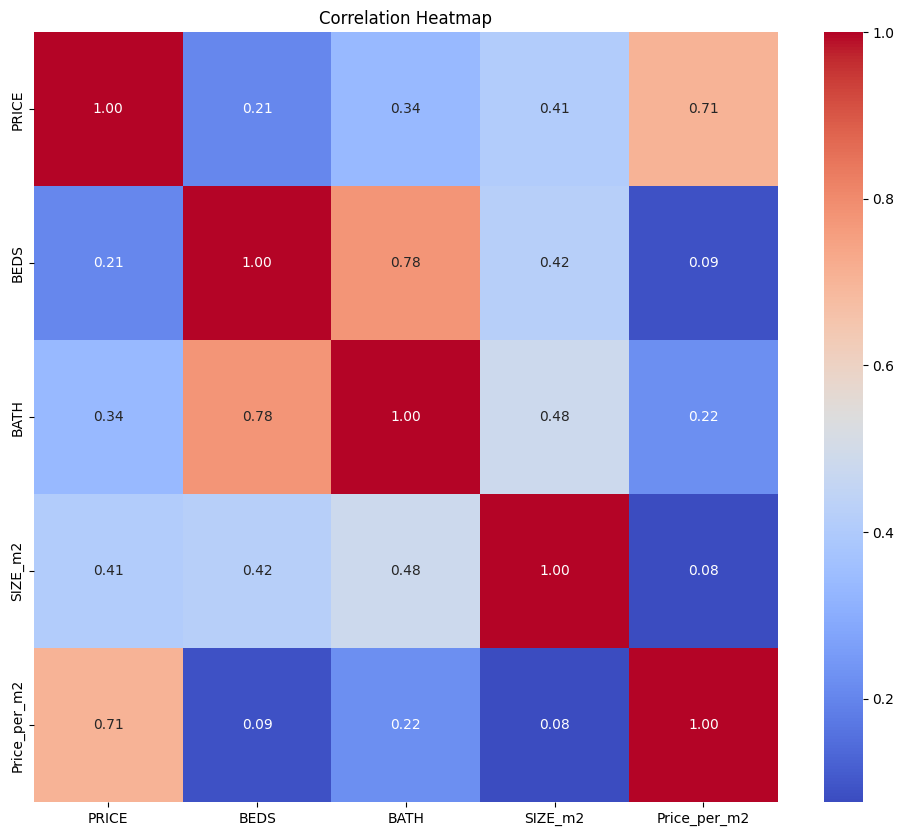

In [20]:
heat_data = df[["PRICE","BEDS","BATH","SIZE_m2","Price_per_m2"]]
correlation_matrix = heat_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


In [21]:
#We select the useful columns
selected_columns = ["BEDS", "BATH", "SIZE_m2", "Price_per_m2", "TYPE", "SUBLOCALITY", "PRICE"]
df_selected = df[selected_columns]

In [22]:
# Perform one-hot encoding
encoder = OneHotEncoder(drop="first", sparse_output=False)
X_encoded = pd.DataFrame(encoder.fit_transform(df_selected[['TYPE', 'SUBLOCALITY']]))
X_encoded.columns = encoder.get_feature_names_out(['TYPE', 'SUBLOCALITY'])


# Normalize numerical features
scaler = StandardScaler()
numerical_columns = ["BEDS", "BATH", "SIZE_m2", "Price_per_m2"]
X_numerical = df_selected[numerical_columns]
X_numerical_scaled = pd.DataFrame(scaler.fit_transform(X_numerical), columns=numerical_columns)
# Concatenate
X = pd.concat([X_encoded,X_numerical_scaled], axis=1)
y = df_selected["PRICE"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [24]:
coefficients = linear_model.coef_
intercept = linear_model.intercept_

In [25]:
y_log = np.log(y_train)
linear_model_log = LinearRegression()
linear_model_log.fit(X_train, y_log)

LinearRegression()

In [26]:
coefficients_log = linear_model_log.coef_
intercept_log = linear_model_log.intercept_


In [27]:
y_log_test = np.log(y_test)
predictions_log = linear_model_log.predict(X_test)
mse_log = mean_squared_error(y_log_test, predictions_log)

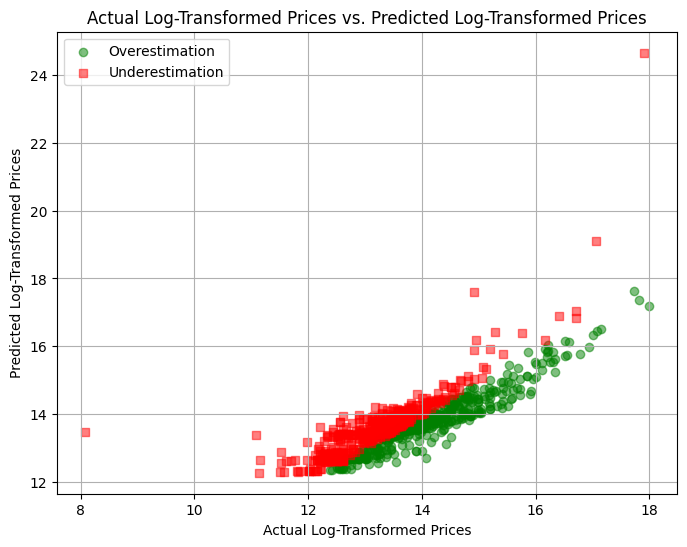

In [28]:
colors = np.where(y_log_test > predictions_log, 'g', 'r')

plt.figure(figsize=(8, 6))

plt.scatter(y_log_test[colors == 'g'], predictions_log[colors == 'g'], alpha=0.5, c='g', marker='o', label='Overestimation')

plt.scatter(y_log_test[colors == 'r'], predictions_log[colors == 'r'], alpha=0.5, c='r', marker='s', label='Underestimation')

plt.title('Actual Log-Transformed Prices vs. Predicted Log-Transformed Prices')
plt.xlabel('Actual Log-Transformed Prices')
plt.ylabel('Predicted Log-Transformed Prices')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
print("Linear Regression Coefficients:", coefficients)
print("Linear Regression Intercept:", intercept)
print("\nLinear Regression (Log-Transformed) Coefficients:", coefficients_log)
print("Linear Regression (Log-Transformed) Intercept:", intercept_log)
print("MSE of Log-Transformed Model:", mse_log)

Linear Regression Coefficients: [-6.07439417e+04 -1.91405134e+05  4.45468536e+05 -7.25937269e+04
 -8.60290940e+05  2.95445049e+05 -1.18347537e+05 -1.62408701e+05
 -6.40284270e-10 -6.65293511e+05 -7.92481585e+04 -4.75764223e+04
 -7.80288269e+04 -6.96736499e+05  9.79692983e+04 -8.14907253e-10
 -4.65661287e-10  2.10486315e+05 -3.61361245e+05 -8.22398678e+04
 -4.83519006e+04 -9.52731083e+05 -3.26635174e+05  2.31181813e+06
  1.29003448e+05 -4.83299955e+04  5.77890933e+05 -5.85632810e+04
  3.30343376e+05  1.86970025e+05  4.10405968e+05  4.19379331e+05
 -9.65091173e+04  2.82791934e+05  1.51468933e+06  3.17836940e+06]
Linear Regression Intercept: 1995740.7871251875

Linear Regression (Log-Transformed) Coefficients: [-3.71794377e-02  4.60057035e-01  2.10243620e-01  2.73810800e-01
  1.03517881e-01  2.46479837e-01  4.63614696e-01  8.57758906e-02
 -5.68989300e-16  4.83410416e-01  3.36237585e-01  6.98509622e-01
  7.70961534e-02  3.61187709e-01 -1.61865966e-01  3.88578059e-16
  3.33066907e-16  6.091

**Original Linear Regression:**

*Coefficients:*
- The coefficients represent the change in the dependent variable for a one-unit change in the corresponding independent variable, holding other variables constant.
- For example, a one-unit increase in the variable at index 0 (`-6.07439417e+04`) would result in a decrease of approximately $60,743 in the dependent variable, assuming other variables are constant.

*Intercept:*
- The intercept (`1995740.7871251875`) is the predicted value of the dependent variable when all independent variables are zero.
- In this context, it doesn't have a direct interpretation because many features are not truly zero in the dataset.

**Log-Transformed Linear Regression:**

*Coefficients:*
- The coefficients represent the percentage change in the dependent variable for a one-unit change in the corresponding independent variable, holding other variables constant. This is due to the log transformation of the target variable.
- For example, a one-unit increase in the variable at index 0 (`-3.71794377e-02`) corresponds to a decrease of approximately 3.72% in the predicted log-transformed price.

*Intercept:*
- The intercept (`13.185265015823612`) is the predicted log-transformed price when all independent variables are zero.
- Exponentiating this value (`np.exp(13.185265015823612)`) gives the geometric mean of the original prices, which represents the predicted median price.

**Mean Squared Error (MSE) of Log-Transformed Model:**

- The MSE (`0.3058968606226447`) measures the average squared difference between actual and predicted log-transformed prices on the test set.
- A lower MSE indicates better model performance, but the interpretation is easier when back-transformed to the original scale.

## Question 4

A decision tree is a supervised machine learning algorithm used for both classification and regression tasks. It works by recursively partitioning the input space (feature space) into regions and assigning a label or making a prediction for each region. This is how they work:

1. **Initialization:**
   - The algorithm starts with the entire dataset, considering all available features.

2. **Feature Selection:**
   - It evaluates different features to find the one that best splits the dataset into homogenous groups (nodes) based on some criterion. The commonly used criteria include Gini impurity for classification tasks or mean squared error for regression tasks.

3. **Splitting:**
   - The selected feature is used to split the dataset into subsets. Each subset represents a branch of the tree, and the split is chosen to maximize the homogeneity within each subset.

4. **Recursion:**
   - Steps 2 and 3 are repeated recursively for each subset until a stopping criterion is met. This could be a predefined depth of the tree, a minimum number of samples in a leaf node, or other criteria.

5. **Leaf Nodes:**
   - Once a stopping criterion is met, the algorithm assigns a label or predicts a value for each leaf node. In a classification task, the majority class in the leaf node is assigned as the label. In a regression task, the mean or median of the target values in the leaf node is used as the prediction.

6. **Prediction:**
   - To make a prediction for a new input, the input traverses the tree from the root to a leaf node based on the values of its features. The label or predicted value at the leaf node is then assigned to the input.

In [30]:
tree_model = DecisionTreeRegressor()

tree_model.fit(X_train, y_log)

feature_names = list(X_train.columns)

plt.figure(figsize=(25, 25))
tree.plot_tree(tree_model, feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.show()
predictions_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_log_test, predictions_tree)

print("Mean Squared Error of Decision Tree Model:", mse_tree)

KeyboardInterrupt: 

The decision tree seems to have a lot of branches and to be very deep.

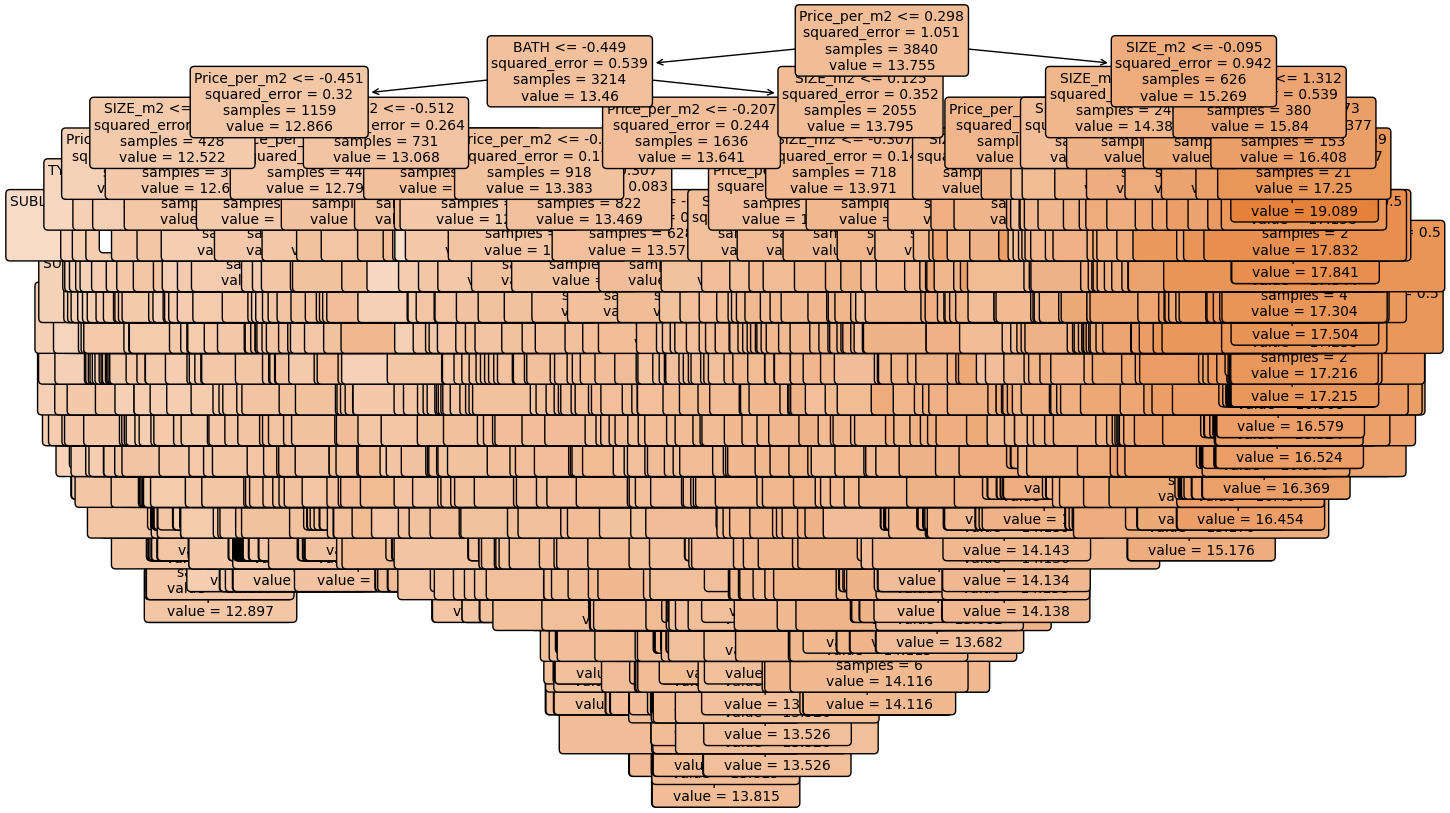

Best Hyperparameters for Decision Tree: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error of Best Decision Tree Model: 0.006768583665377972


In [ ]:
param_grid = {'max_depth': [None, 10, 20, 30],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

tree_model = DecisionTreeRegressor()

grid_search_tree = GridSearchCV(tree_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_tree.fit(X_train, y_log)

best_params_tree = grid_search_tree.best_params_

best_model_tree = grid_search_tree.best_estimator_
predictions_best_tree = best_model_tree.predict(X_test)

mse_best_tree = mean_squared_error(y_log_test, predictions_best_tree)

best_tree_model = grid_search_tree.best_estimator_

plt.figure(figsize=(15, 10))
tree.plot_tree(best_tree_model, feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.show()

print("Best Hyperparameters for Decision Tree:", best_params_tree)
print("Mean Squared Error of Best Decision Tree Model:", mse_best_tree)

After optimizing the hyper parameters with a grid search the trees look very similar the best max depth being None.

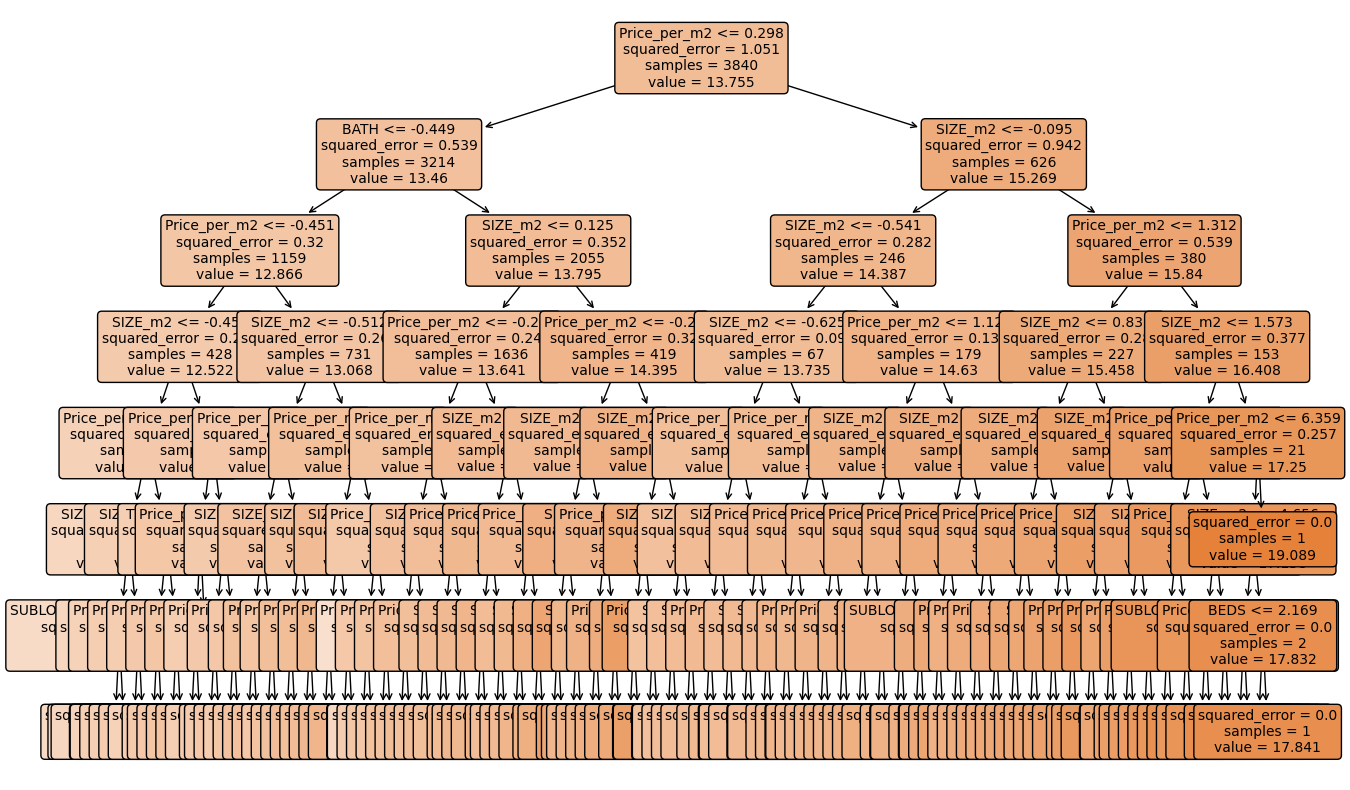

Best Hyperparameters for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error of Best Decision Tree Model: 0.02574934458726167


In [ ]:
param_grid = {'max_depth': [2, 5, 7],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

tree_model = DecisionTreeRegressor()

grid_search_tree = GridSearchCV(tree_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_tree.fit(X_train, y_log)

best_params_tree = grid_search_tree.best_params_

best_model_tree = grid_search_tree.best_estimator_
predictions_best_tree = best_model_tree.predict(X_test)

mse_best_tree = mean_squared_error(y_log_test, predictions_best_tree)

best_tree_model = grid_search_tree.best_estimator_

plt.figure(figsize=(15, 10))
tree.plot_tree(best_tree_model, feature_names=feature_names, filled=True, rounded=True, fontsize=10)
plt.show()

print("Best Hyperparameters for Decision Tree:", best_params_tree)
print("Mean Squared Error of Best Decision Tree Model:", mse_best_tree)

The Mean Squared Error (MSE) is a measure of the average squared difference between the predicted values and the actual values. In your case, you have a Log-Transformed Model with an MSE of 0.3058968606226447 and a Decision Tree Model with an MSE of 0.007404082156736556.

In general, a lower MSE indicates a better-performing model. Therefore, based on the MSE values you provided:

- The Decision Tree Model has a significantly lower MSE (0.0074) compared to the Log-Transformed Model (0.3059).

Given this information, the Decision Tree Model appears to yield better results in terms of predictive accuracy, as it has a lower mean squared error.

## QUESTION 5

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Create a Random Forest regressor
rf_model = RandomForestRegressor()

# Define the parameter grid for hyperparameter tuning
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV for Random Forest
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
rf_grid_search.fit(X_train, y_log)

# Get the best parameters for Random Forest
best_rf_params = rf_grid_search.best_params_

# Print the best parameters for Random Forest
print("Best Hyperparameters for Random Forest:", best_rf_params)

# Get the best Random Forest model
best_rf_model = rf_grid_search.best_estimator_

# Evaluate the Random Forest model on the test set
predictions_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_log_test, predictions_rf)

print("Mean Squared Error of Random Forest Model:", mse_rf)

# Print feature importances
feature_importances = best_rf_model.feature_importances_
feature_importance_dict = dict(zip(X_train.columns, feature_importances))

# Sort features by importance in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted feature importances
print("\nFeature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Best Hyperparameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Mean Squared Error of Random Forest Model: 0.004421017974054167

Feature Importances:
Price_per_m2: 0.6037588787255574
SIZE_m2: 0.22966364576641082
BATH: 0.16200290724626393
SUBLOCALITY_New York: 0.0011400436179872138
TYPE_For sale: 0.0010028222697203682
BEDS: 0.0007283354373716571
SUBLOCALITY_Brooklyn: 0.0005904026007839708
TYPE_Multi-family home for sale: 0.00022510368124045008
TYPE_Condo for sale: 0.00014778286653851486
TYPE_Townhouse for sale: 0.0001076669629436375
SUBLOCALITY_Queens County: 0.0001061385606517426
SUBLOCALITY_Kings County: 8.934820533277559e-05
TYPE_House for sale: 8.315146126145619e-05
SUBLOCALITY_Richmond County: 8.209148132548945e-05
SUBLOCALITY_The Bronx: 7.635687197118617e-05
SUBLOCALITY_New York County: 6.246408970832318e-05
SUBLOCALITY_Staten Island: 2.906718971865816e-05
TYPE_Pending: 2.7764964867354678e-05
SUBLOCALITY_Queens: 2.294

The Random Forest Model outshines the Log-Transformed Model with a significantly lower Mean Squared Error (MSE) of 0.0044, demonstrating superior predictive accuracy. When scrutinizing the variable importance in the Random Forest Model, three key features emerge as major contributors to the model's decision-making. Notably, "Price_per_m2" holds the highest importance at 60.38%, emphasizing the critical role of the price per square meter in predicting the target variable. Following closely are "SIZE_m2" at 22.97% and "BATH" at 16.20%, underscoring the significance of property size and the number of bathrooms in influencing predictions. These insights suggest that properties with higher prices per square meter, larger sizes, and more bathrooms exert a substantial impact on the model's accuracy. The MSE comparison and variable importance collectively endorse the Random Forest Model as the preferred choice, providing a robust framework for predicting real estate prices while highlighting the key factors that drive accurate predictions.